In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(
    num_train_timesteps=1000, 
    beta_start=0.001, 
    beta_end=0.02
)

In [4]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=3,
    sample_size=64,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

2025-05-12 11:54:15.616908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747050855.790303      55 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747050855.843423      55 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, image_size=64):
        self.root_dir = root_dir
        self.image_files = sorted(os.listdir(root_dir))
        self.transform = transforms.Compose([
            transforms.CenterCrop(140),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        return self.transform(image)

image_folder = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
dataset = CelebADataset(image_folder, image_size=64)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

images = next(iter(dataloader))
print("Sample batch shape:", images.shape)

Sample batch shape: torch.Size([64, 3, 64, 64])


In [6]:
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

start_epoch = 0
checkpoint_path = "checkpoints/last_checkpoint.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("Starting training from scratch.")

Starting training from scratch.


In [7]:
losses = []
os.makedirs("checkpoints", exist_ok=True)
total_epochs = 10

for epoch in range(start_epoch, total_epochs):
    model.train()

    for batch in dataloader:
        clean_images = batch.to(device)
        noise = torch.randn_like(clean_images).to(device)
        timesteps = torch.randint(
            0, scheduler.config.num_train_timesteps, 
            (clean_images.shape[0],), device=device
        ).long()

        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_pred, noise)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        gc.collect()
        torch.cuda.empty_cache()

    # Save checkpoints
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, f"checkpoints/epoch_{epoch:02d}.pth")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, "checkpoints/last_checkpoint.pth")

    avg_loss = sum(losses[-len(dataloader):]) / len(dataloader)
    print(f"Finished epoch {epoch}. Average loss: {avg_loss:.6f}")

Finished epoch 0. Average loss: 0.023731
Finished epoch 1. Average loss: 0.013016
Finished epoch 2. Average loss: 0.012353
Finished epoch 3. Average loss: 0.011855
Finished epoch 4. Average loss: 0.011655
Finished epoch 5. Average loss: 0.011510
Finished epoch 6. Average loss: 0.011344
Finished epoch 7. Average loss: 0.011382
Finished epoch 8. Average loss: 0.011184
Finished epoch 9. Average loss: 0.011188


In [10]:
with open('losses.txt', 'w') as file:
    for loss in losses:
        file.write(f"{loss}\n")

  0%|          | 0/1000 [00:00<?, ?it/s]

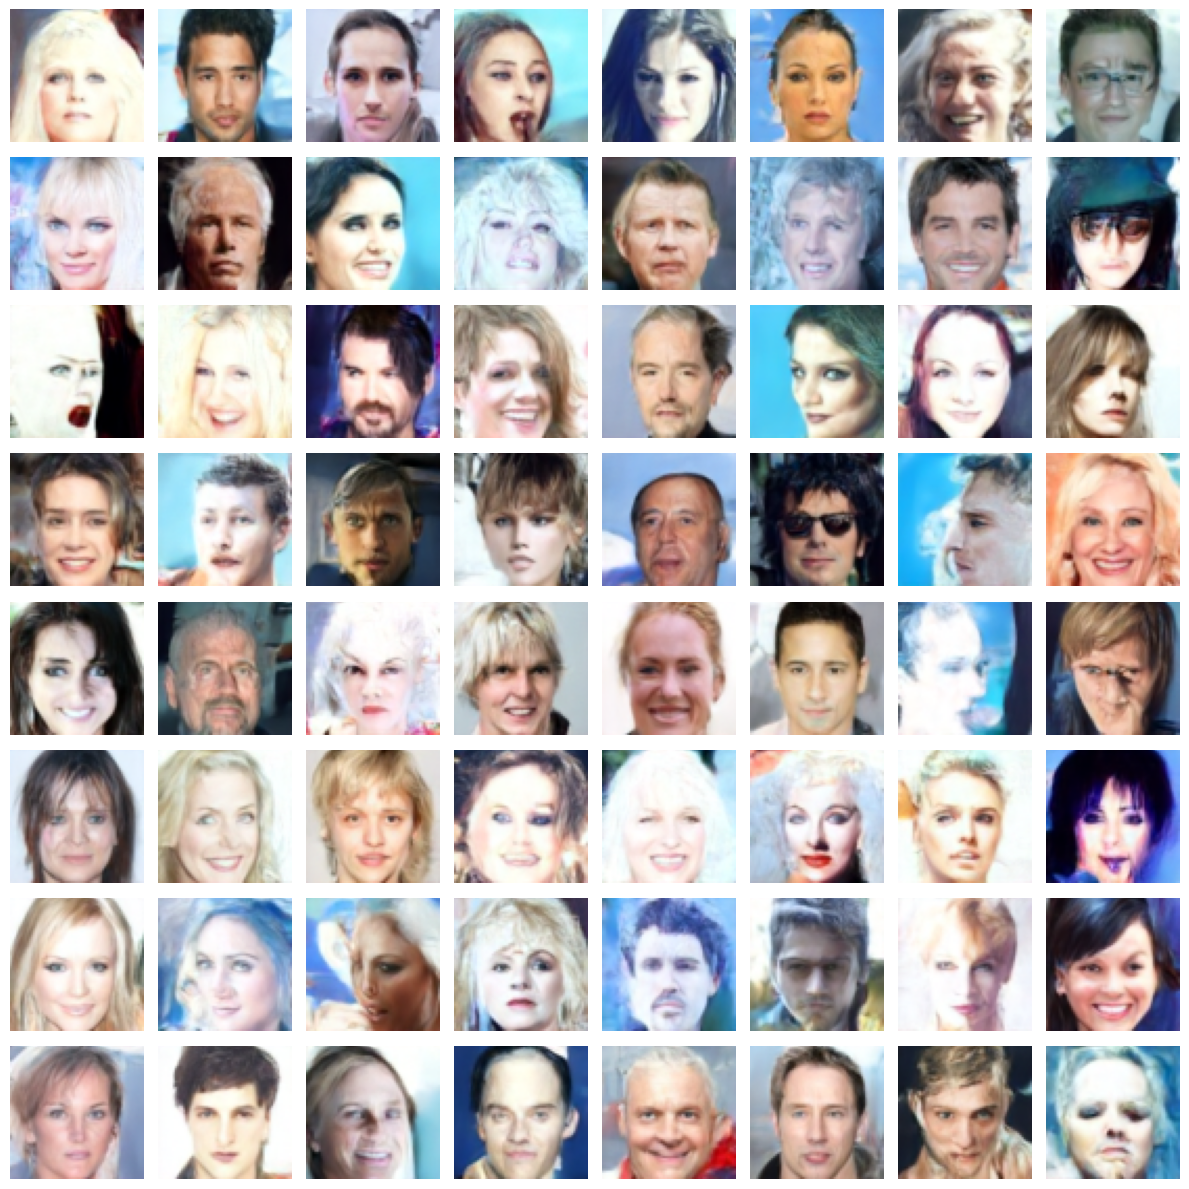

In [12]:
from diffusers import DDPMPipeline
from torchvision.utils import save_image, make_grid
import numpy as np

model.eval()
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)

with torch.no_grad():
    ims = pipeline(batch_size=64).images

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i, img in enumerate(ims):
    row, col = divmod(i, 8)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

grid_tensor = torch.tensor(np.stack([transforms.ToTensor()(img) for img in ims]))
grid = make_grid(grid_tensor, nrow=8, normalize=True)
save_image(grid, "generated_images.png")

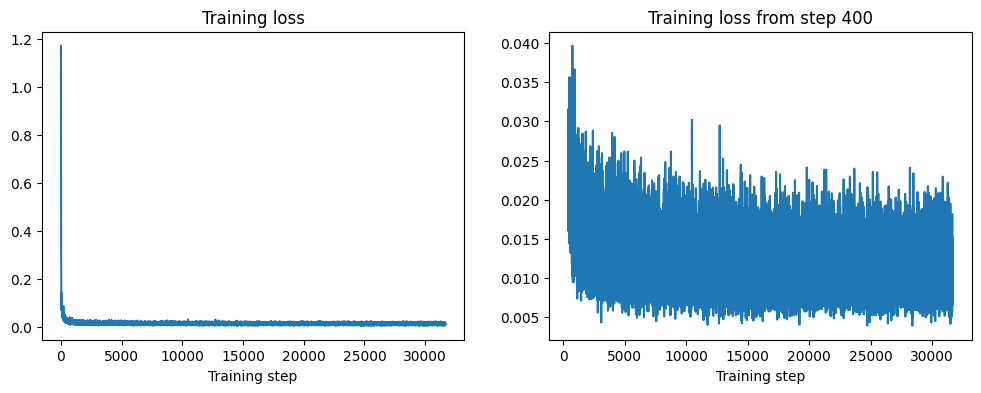

In [14]:
plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step");